# Разработка модели МО для оптимизации расходов и увеличения рентабельности при бурении скважин для компании «ГлавРосГосНефть»

## Цели исследования.

- Загрузить и проанализировать данные присланные заказчиком , для выявления аномалий и дефектов данных.



- Построение модели МО для нахождения скважин с самым высоким потенциалом с целью оптимизации расходов и увеличения прибыли.



- Проанализировать потенциальную прибыль и эффективность от внедрения модели.

## Ход исследования.

- Загрузка и первичное ознакомление с данными заказчика.


- Анализ "чистоты" данных с целью выявления пропусков и аномальных значений.


- Построение модели МО для с целью рейтинговой классификации скважин.


- Оценка прибыли и рисков при внедрении модели.


- Финальный вывод.

## Описание поступивших данных.

`id` — уникальный идентификатор скважины ;

`f0, f1, f2` — три признака точек ;

`product` — объём запасов в скважине (тыс. баррелей).

## Технический модуль.



In [51]:
#%pip install ydata-profiling


### Импорт библиотек.

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
import time
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import (r2_score, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             accuracy_score, precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Определение констант


In [2]:
RS = 42 #random state 

### Создание функций.

In [3]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

In [4]:
sns.set_style('whitegrid')
sns.set_palette('RdYlBu')
def graph_cat(df, columns, title, xlabel):
    """
    Визуализирует категориальные данные с помощью круговой диаграммы и столбчатой диаграммы.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные.
    columns : str
        Название столбца с категориальными данными для визуализации.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    df[columns].value_counts().plot(kind='pie', y='count', x='subscription_type',
                           colors=sns.color_palette('plasma'),ax=ax[0], autopct='%1.1f%%')
    ax[0].set_title('Процентное ' + title)
    ax[0].set_ylabel(' ')

    sorted_order = df[columns].value_counts().sort_values(ascending=False).index
    sns.countplot(data=df, y=columns, ax=ax[1], order=sorted_order, palette='plasma')
    #sns.countplot(data=df, x=columns, ax=ax[1], palette=['grey', 'orange', 'lightblue'], orient='h')
    ax[1].set_title('Колличественное '+ title)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Тип переменной')

In [5]:
def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')

## Загрузка и первичное ознакомление с данными.

In [6]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df_0 = pd.read_csv(r'C:\Jupi\datasets\geo_data_0.csv')
try:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_1 = pd.read_csv(r'C:\Jupi\datasets\geo_data_1.csv')
try:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_2 = pd.read_csv(r'C:\Jupi\datasets\geo_data_2.csv')

### df_0

In [7]:
df_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [8]:
ProfileReport(df_0, title="Profiling Report", minimal=True, progress_bar=False)

100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


### df_1

In [9]:
df_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
ProfileReport(df_1, title="Profiling Report", minimal=True, progress_bar=False)

100%|██████████| 5/5 [00:00<00:00, 11.39it/s]


### df_2

In [11]:
df_2.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [12]:
ProfileReport(df_2, title="Profiling Report", minimal=True, progress_bar=False)

100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


### Вывод

- Мы загрузили данные заказчика и применили библиотеку ydata для анализа поступивших датафреймов.


- В **df_1** в переменной *product* обнаружилось 8235 знаний содержащих *0* , на этапе предобработки ознакомимся с этим подробней для того что бы выяснить можно ли считать эти значения аномальными.


- Так же во всех датафреймах в столбце *id* наблюдаются дубликаты.



- В остальных переменных наборов данных каких либо явных аномалий обнаружить не удалось.

## Предобработка данных.

На этапе первичного ознакомления с данными мы обнаружили дубликаты в переменной *id* которая должна содержать исключительно уникальные значения.

Изучим этот дефект подробней.

### Обработка неяных дубликатов.

In [13]:
df_0[df_0['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [14]:
df_1[df_1['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [15]:
df_2[df_2['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Как и предполагалось были обнаружены немногочисленные дубликаты в столбце *id* во всех датафреймах , так как нет возможности уточнить данные у заказчика , а так же учитывая незначительный размер дубликатов , примем решение об их удалении оставив только первое появление значения в данных.

In [16]:
display(df_0.shape)
df_0.drop_duplicates(subset='id', keep='first', inplace=True)
df_0 = df_0.reset_index(drop=True)
display(df_0.shape)


(100000, 5)

(99990, 5)

In [17]:
display(df_1.shape)
df_1.drop_duplicates(subset='id', keep='first', inplace=True)
df_1 = df_1.reset_index(drop=True)
display(df_1.shape)


(100000, 5)

(99996, 5)

In [18]:
display(df_2.shape)
df_2.drop_duplicates(subset='id', keep='first', inplace=True)
df_2 = df_2.reset_index(drop=True)
display(df_2.shape)


(100000, 5)

(99996, 5)

Мы удалили неявные дубликаты в наших датасетах , повысив "чистоту" данных что позволит получить более качественные предсказания модели МО.

### Вывод

- На этапе первичного ознакомления мы выявили незначительные дефекты в данных в виде неявных дубликатов в переменной *id*. Мы обработали повторы , оставив в данных только первые появления дублирующих данных.

## Исследовательский анализ данных.

Для какой либо аналитической оценки нам доступен только параметр *product* который содержит показатель объема запасов содержащихся в скважине. Возможно удастся обнаружиться интересные для бизнеса закономерности или же какие либо явные отклонения.

### Анализ переменной *product*

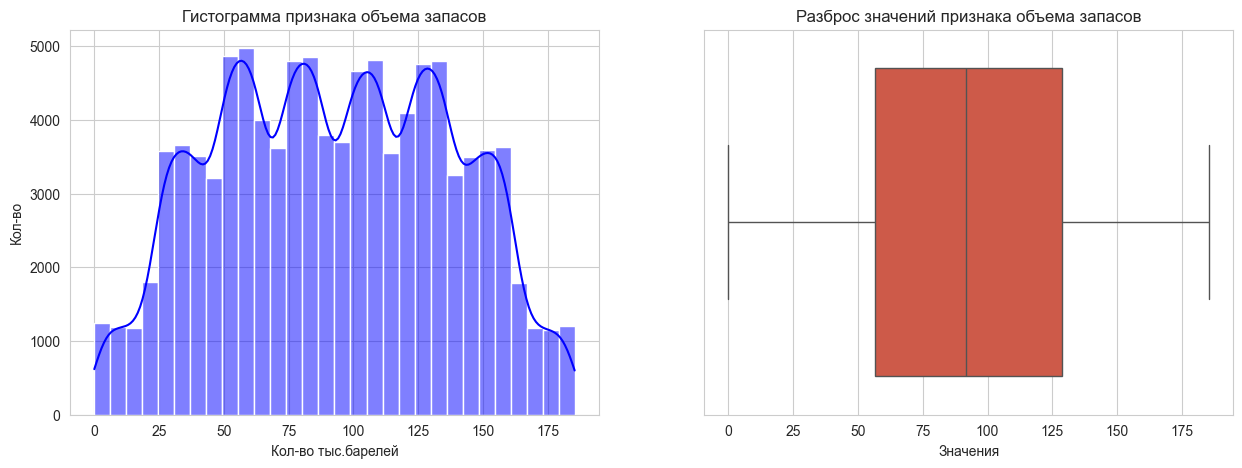

In [19]:
%matplotlib inline
graph_num(df_0, 'product', 'объема запасов', 'Кол-во тыс.барелей', bins=30)


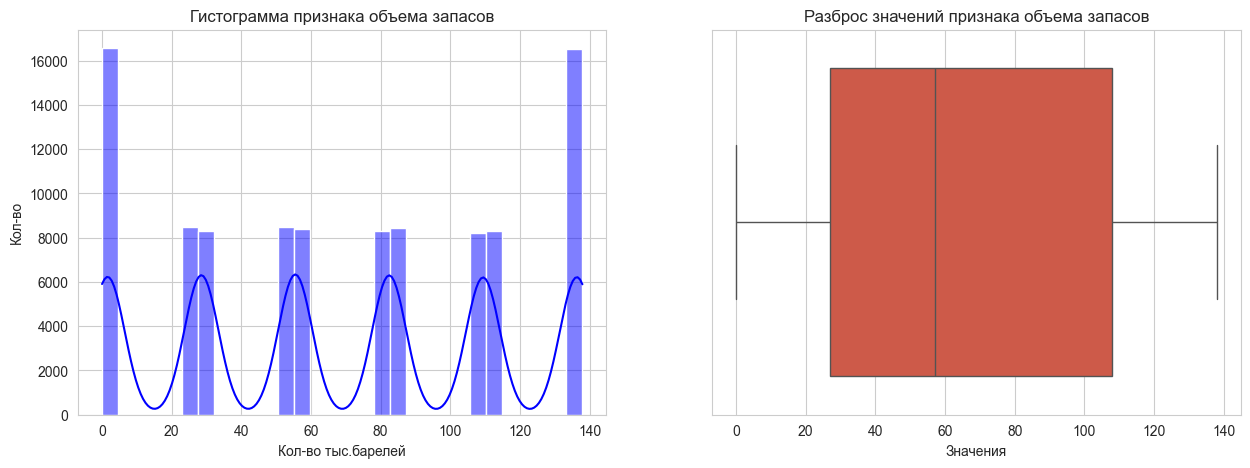

In [20]:
graph_num(df_1, 'product', 'объема запасов', 'Кол-во тыс.барелей', bins=30)


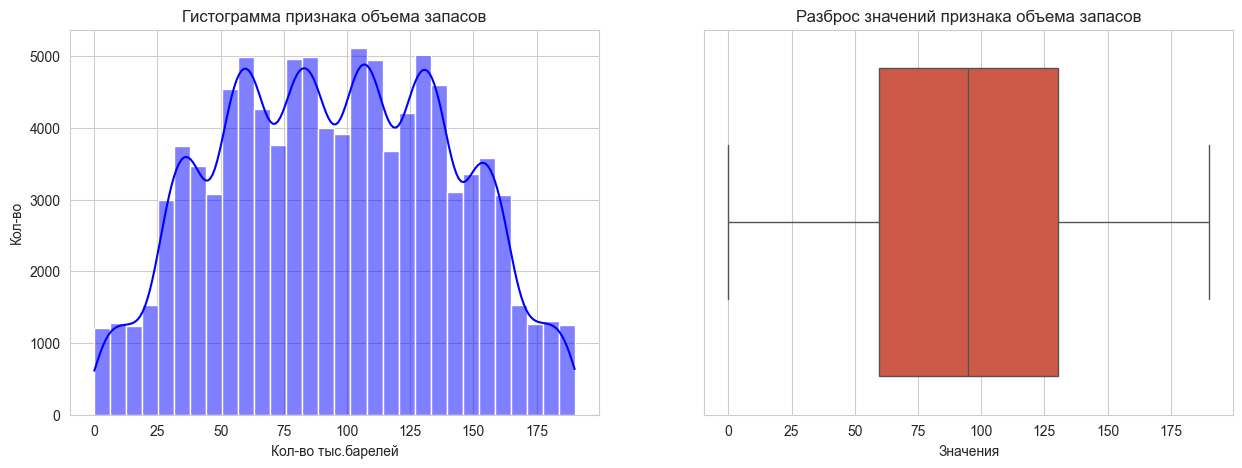

In [21]:
graph_num(df_2, 'product', 'объема запасов', 'Кол-во тыс.барелей', bins=30)


Видим что в датасете **df_1** целевая переменная в отличие от остальных наборов данных , приняла *12* уникальных значений , что скорей всего скажется на качестве предсказаний модели.

### Анализ мультиколлинеарности датасетов.

Проанализируем полученные данные на предмет мультиколлинеарности и утечки целевого признака.

Так как по заданию от заказчика мы будем использовать *LinearRegression* модель , проанализируем наши признаки методом "Спирмана" который призван выявлять линейную зависимость в данных.

#### df_0

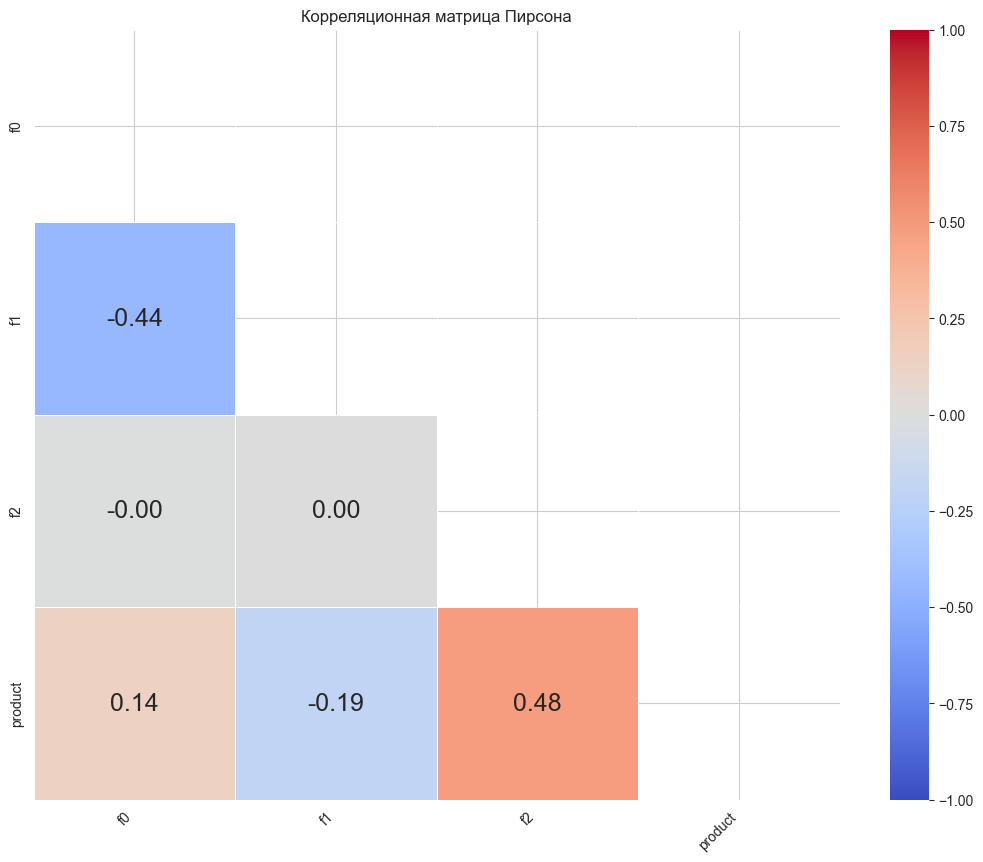

In [22]:
num_cols = df_0.drop('id', axis=1).select_dtypes(include=['int64', 'float64']).columns
tri = np.triu(np.ones_like(df_0[num_cols].corr(), dtype=bool))
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    df_0[num_cols].corr('pearson'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Пирсона")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

Явной корреляции обнаружить не удалось данные можно оставить в исходном виде.

#### df_1

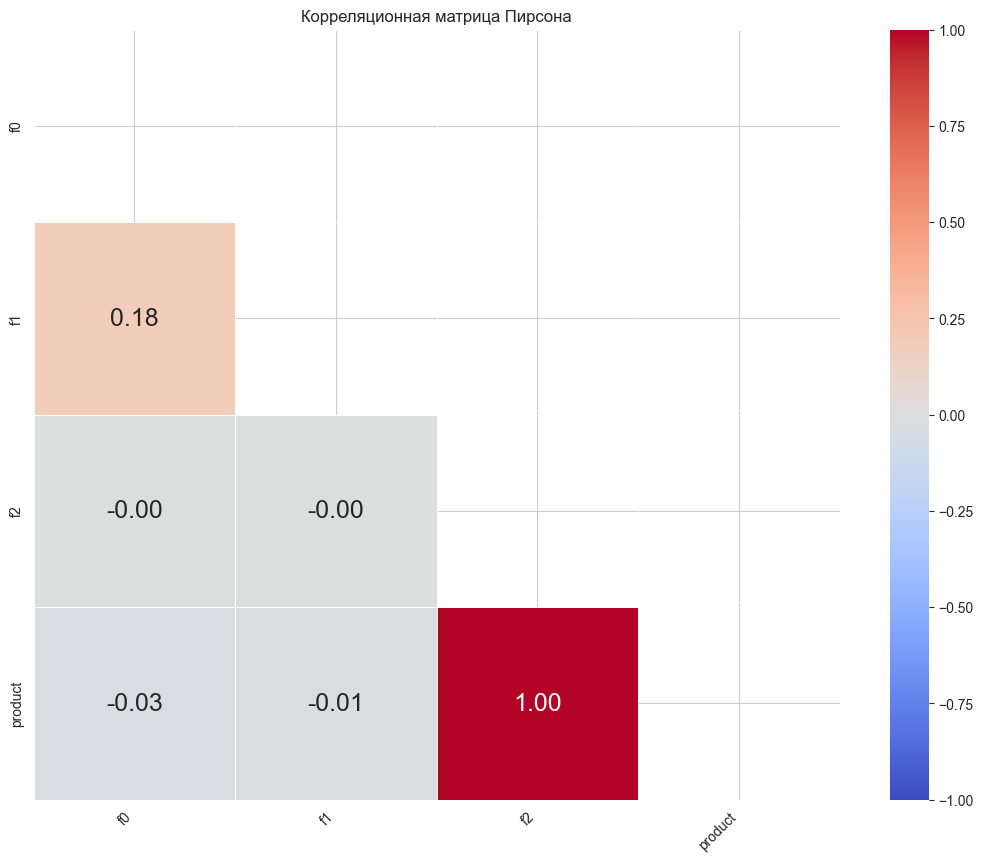

In [23]:
num_cols = df_0.drop('id', axis=1).select_dtypes(include=['int64', 'float64']).columns
tri = np.triu(np.ones_like(df_0[num_cols].corr(), dtype=bool))
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    df_1[num_cols].corr('pearson'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Пирсона")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

Видим 100% линейную зависимость нашей целевой переменной с признаком *f2*

Воспользуемся так же библиотекой vif для определения индекса мультиколлинеарности.

In [24]:
num_cols = df_1.select_dtypes(include='number').columns#.drop('id', axis=1)
vif_num = df_1[num_cols].assign(const=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_1[num_cols].columns
vif_data["VIF"] = [variance_inflation_factor(vif_num, i) for i in range(len(df_1[num_cols].columns))]
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
3,product,2662.639020
2,f2,2660.123168
0,f0,3.163188
1,f1,1.049804


Как видим значения полученные при помощи библиотеки *vif* полностью подтверждают данные полученные при построение матрицы *Пирсона*. Допустимые значения коэффициента vif >10 , а мы получили показатель 2660 в переменной *f2*.

При обучение модели на датасете **df_1** , изолируем признак *f2*

#### df_2

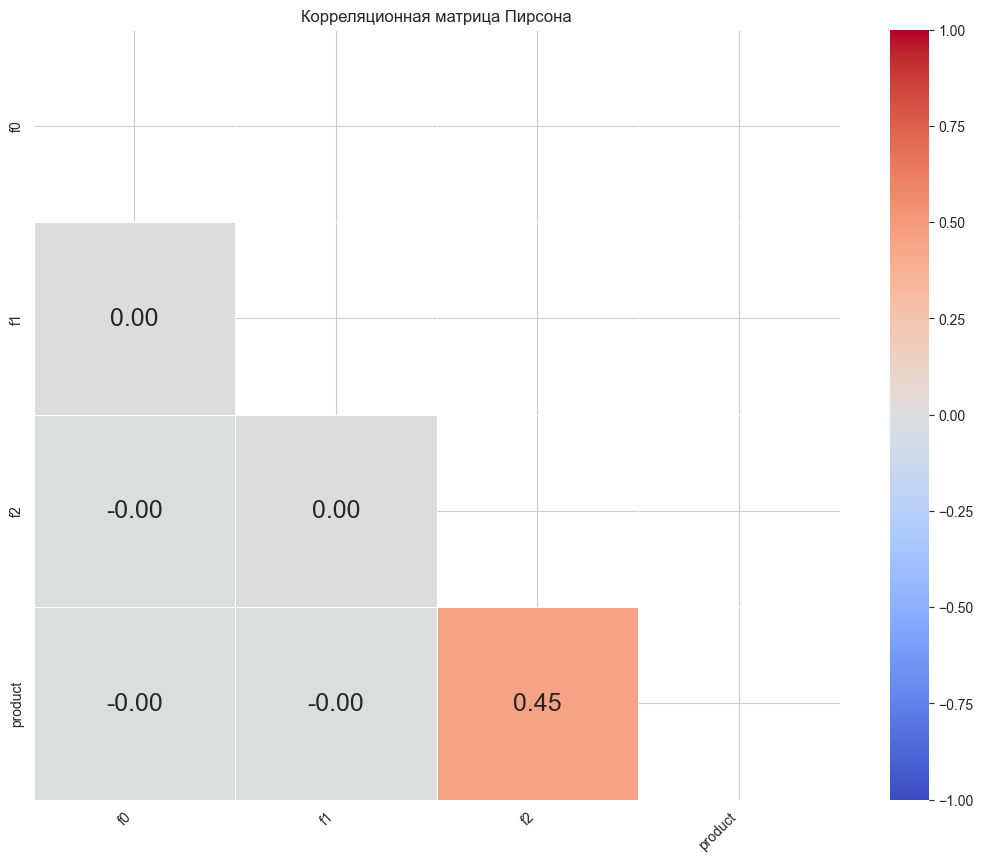

In [25]:
num_cols = df_0.drop('id', axis=1).select_dtypes(include=['int64', 'float64']).columns
tri = np.triu(np.ones_like(df_0[num_cols].corr(), dtype=bool))
plt.figure(figsize=(13, 10))
heatmap = sns.heatmap(
    df_2[num_cols].corr('pearson'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Пирсона")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

Как видим явных линейных закономерностей не обнаружилось , можем использовать представленные данные для обучения модели без предобработки.

### Вывод

Для анализа нам была доступны только наша целевая переменная *product* в ходе исследовательского анализа удалось установить следующие :

- В наборах данных **df_0 , df_2** переменная принимает нормальное распределение.

- В наборе данных **df_1** переменная принимает 12 уникальных значений , внутри этих значений наблюдается небольшой перекос в сторону значений *0 и 137.94* в остальном данные распределены равномерно.

При анализе мультиколлинеарности посредствам матрицы "Спирмана" и библиотеки vif удалось заметить следующие :

- В датасете **df_1** удалось обнаружить линейную зависимость признака *f2* с нашей целевой переменной , которая достигла 100% значения по матрице "Спирмана" и значения 2660 по метрике *vif*.

- При построение модели для **df_1** , изолируем признак *f2* с целью исключения утечки данных.

## Обучение моделей для наших датасетов.

### df_0

#### Создание выборок для датафрейма *df_0*

In [26]:
X = df_0.drop(['id', 'product'], axis=1)
y = df_0['product']

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

#### Создание кастомной метрики

Так как в доступных нам библиотеках не реализована метрика RMSE для перебора в "пайплайне", исправим это посредствам создания собственной метрики на основе *make_scorer*

In [27]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Создаем кастомный скоринг (чем меньше, тем лучше)
custom_scorer = make_scorer(
    rmse,
    greater_is_better=False  # Указываем, что меньше = лучше
)

#### Перебор скейлеров для линейной регрессии

Переберем известные нам способы обработки непрерывных числовых признаков и проанализируем их влияние на работу модели.

In [28]:
scalers = [
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler()),
    ('Без масштабирования', None)  
]

results = {}

for scaler_name, scaler in scalers:
    
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', LinearRegression()),

    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=custom_scorer)
    
    results[scaler_name] = np.abs(scores.mean())
    
    print(f"{scaler_name}: RMSE = {np.abs(scores.mean()):.4f}")

best_scaler = min(results, key=results.get)


StandardScaler: RMSE = 37.6969
MinMaxScaler: RMSE = 37.6969
RobustScaler: RMSE = 37.6969
Без масштабирования: RMSE = 37.6969


Видим что выбор енкодера никаким образом не повлиял на значения метрики. Поэтому в дальнейшем для обработки данных будем использовать StandardScaler.

#### Создание модели

In [29]:
lin_pipelina = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lin_pipelina.fit(X_train, y_train)
scores = cross_val_score(lin_pipelina, X_train, y_train, cv=5, scoring=custom_scorer)

X_test = lin_pipelina.named_steps['scaler'].transform(X_test)
y_pred = lin_pipelina.named_steps['model'].predict(X_test)
score = custom_scorer._score_func(y_test, y_pred)


In [30]:
print(f"Значение метрики RMSE на тестовой выборке : {np.abs(scores.mean()):.4f}")
print(f"Значение метрики RMSE на валидационной выборке : {score:.4f}")
print(f"Средние значение оставшегося сырья по предсказаниям модели : {y_pred.mean():.2f} т.бар.")
print(f"Фактическое значение оставшегося сырья : {y_test.mean():.2f} т.бар.")

Значение метрики RMSE на тестовой выборке : 37.6969
Значение метрики RMSE на валидационной выборке : 37.6851
Средние значение оставшегося сырья по предсказаниям модели : 92.61 т.бар.
Фактическое значение оставшегося сырья : 92.39 т.бар.


#### Сохранение результатов.

Добавим данные предсказаний к основному датафрейму.

In [31]:
all_pred = lin_pipelina.predict(X)
all_pred = pd.DataFrame(all_pred, columns=['predictions'])
df_0 = pd.concat([df_0, all_pred], axis=1)
df_0
#custom_scorer._score_func(y, all_pred)

,id,f0,f1,f2,product,predictions
0,txEyH,0.705745,-0.497823,1.221170,105.280062,95.419491
1,2acmU,1.334711,-0.340164,4.365080,73.037750,116.241552
2,409Wp,1.022732,0.151990,1.419926,85.265647,88.718694
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,95.306086
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,114.195844
...,...,...,...,...,...,...
99985,DLsed,0.971957,0.370953,6.075346,110.744026,116.147135
99986,QKivN,1.392429,-0.382606,1.273912,122.346843,96.663624
99987,3rnvd,1.029585,0.018787,-1.348308,64.375443,72.365659
99988,7kl59,0.998163,-0.528582,1.583869,74.040764,99.320768


#### Вывод

- Мы обучили модель линейной регрессии на присланных заказчиком данных и получили результат 37 по метрике *RMSE*(среднеквадратичная ошибка модели) , учитывая размер выборки и тот факт что средние значения целевой переменной достаточно близки друг к другу , результат можно считать удовлетворительным.

### df_1

На этапе исследовательского анализа данных мы установили линейную зависимость между переменной *f2* и целевым признаком. Проведем обучение двух моделей с учетом признака *f2* и с его последующей изоляцией , для предоставления заказчику полного объема данных.

#### Создание выборок для df_1

Выборка с участием признака *f2*

In [32]:
X1 = df_1.drop(['id', 'product'], axis=1)
y1 = df_1['product']

X_train_1, X_test_1 , y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.25, random_state=RS)

Выборка с изоляцией признака *f2*

In [33]:
X11 = df_1.drop(['id', 'product', 'f2'], axis=1)
y11 = df_1['product']

X_train_11, X_test_11 , y_train_11, y_test_11 = train_test_split(X11, y11, test_size=0.25, random_state=RS)

#### Обучение модели 

Модель и предсказания с участием переменной *f2*

In [34]:
lin_pipelina_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lin_pipelina_1.fit(X_train_1, y_train_1)
scores_1 = cross_val_score(lin_pipelina_1, X_train_1, y_train_1, cv=5, scoring=custom_scorer)


X_test_1 = lin_pipelina_1.named_steps['scaler'].transform(X_test_1)
y_pred_1 = lin_pipelina_1.named_steps['model'].predict(X_test_1)
score_1 = custom_scorer._score_func(y_test_1, y_pred_1)


In [35]:
print(f"Значение метрики RMSE на тестовой выборке : {np.abs(scores_1.mean()):.4f}")
print(f"Значение метрики RMSE на валидационной выборке : {score_1:.4f}")
print(f"Средние значение оставшегося сырья по предсказаниям модели : {y_pred_1.mean():.2f} т.бар.")
print(f"Фактическое значение оставшегося сырья : {y_test_1.mean():.2f} т.бар.")

Значение метрики RMSE на тестовой выборке : 0.8896
Значение метрики RMSE на валидационной выборке : 0.8928
Средние значение оставшегося сырья по предсказаниям модели : 68.58 т.бар.
Фактическое значение оставшегося сырья : 68.58 т.бар.


Как видим значения метрики RMSE достигло аномально высоких значений в **0.88** , что возможно указывает на утечку целевого признака.

Проведем еще одну итерацию обучения модели с изоляцией переменной *f2*.

In [36]:
lin_pipelina_11 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lin_pipelina_11.fit(X_train_11, y_train_11)
scores_11 = cross_val_score(lin_pipelina_11, X_train_11, y_train_11, cv=5, scoring=custom_scorer)


X_test_11 = lin_pipelina_11.named_steps['scaler'].transform(X_test_11)
y_pred_11 = lin_pipelina_11.named_steps['model'].predict(X_test_11)
score_11 = custom_scorer._score_func(y_test_11, y_pred_11)


In [37]:
print(f"Значение метрики RMSE на тестовой выборке : {np.abs(scores_11.mean()):.4f}")
print(f"Значение метрики RMSE на валидационной выборке : {score_11:.4f}")
print(f"Средние значение оставшегося сырья по предсказаниям модели : {y_pred_11.mean():.2f} т.бар.")
print(f"Фактическое значение оставшегося сырья : {y_test_11.mean():.2f} т.бар.")

Значение метрики RMSE на тестовой выборке : 45.9180
Значение метрики RMSE на валидационной выборке : 45.9422
Средние значение оставшегося сырья по предсказаниям модели : 68.92 т.бар.
Фактическое значение оставшегося сырья : 68.58 т.бар.


Как видим после удаления признака *f2* из обучения , результаты метрики RMSE оказались значительно хуже приняв более правдоподобные значения на уровне значений RMSE из первого региона. 

#### Сохранение результатов

Сохраним все полученные результаты в основном датафрейме.

In [38]:
all_pred_1 = lin_pipelina_1.predict(X1)
all_pred_1 = pd.DataFrame(all_pred_1, columns=['predictions_f2'])
all_pred_11 = lin_pipelina_11.predict(X11)
all_pred_11 = pd.DataFrame(all_pred_11, columns=['predictions'])
df_1 = pd.concat([df_1, all_pred_11, all_pred_1], axis=1)
df_1.head(5)
#custom_scorer._score_func(y, all_pred)

,id,f0,f1,f2,product,predictions,predictions_f2
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,71.479828,3.850104
1,62mP7,14.272088,-3.475083,0.999183,26.953261,66.857391,26.590871
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,68.155335,135.661634
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,71.278391,138.538783
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,67.232023,134.862960


#### Вывод

- Мы провели две итерации обучения модели с присутствием признака *f2* и его удалением. В первом случае метрика RMSE приняла аномально высокие значения в **0.88** что говорит практически об отсутствие каких либо погрешностей в предсказаниях , а так же утечке целевого признака. При проведении второй итерации , результаты RMSE оказались более правдоподобными и приняли среднее значение в **45** , что незначительно  выше чем результаты полученные при исследовании первого региона.

- Из за специфичности данных , а именно целевой переменной принявшей всего 12 уникальных значений , вместо непрерывного распределения , а так же то что модель обучалась на меньшем количестве признаков, метрика *RMSE* оказалась хуже чем в модели обученной на **df_0** , а именно 45. Но средние показатели предсказания оставшегося сырья относительно фактических значений , остаются достаточно близкими , что свидетельствует о целом удовлетворительном результате.

### df_2

#### Создание выборок для датафрейма *df_2*

In [39]:
X2 = df_2.drop(['id', 'product'], axis=1)
y2 = df_2['product']

X_train_2, X_test_2 , y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.25, random_state=RS)

#### Создание модели

In [40]:
lin_pipelina_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lin_pipelina_2.fit(X_train_2, y_train_2)
scores_2 = cross_val_score(lin_pipelina_2, X_train_2, y_train_2, cv=5, scoring=custom_scorer)

X_test_2 = lin_pipelina_2.named_steps['scaler'].transform(X_test_2)
y_pred_2 = lin_pipelina_2.named_steps['model'].predict(X_test_2)
score_2 = custom_scorer._score_func(y_test_2, y_pred_2)


In [41]:
print(f"Значение метрики RMSE на тестовой выборке : {np.abs(scores_2.mean()):.4f}")
print(f"Значение метрики RMSE на валидационной выборке : {score_2:.4f}")
print(f"Средние значение оставшегося сырья по предсказаниям модели : {y_pred_2.mean():.2f} т.бар.")
print(f"Фактическое значение оставшегося сырья : {y_test_2.mean():.2f} т.бар.")

Значение метрики RMSE на тестовой выборке : 40.0477
Значение метрики RMSE на валидационной выборке : 40.0808
Средние значение оставшегося сырья по предсказаниям модели : 94.93 т.бар.
Фактическое значение оставшегося сырья : 95.25 т.бар.


#### Сохранение результатов

In [42]:
all_pred_2 = lin_pipelina_2.predict(X2)
all_pred_2 = pd.DataFrame(all_pred_2, columns=['predictions'])
df_2 = pd.concat([df_2, all_pred_2], axis=1)
df_2.head(5)
#custom_scorer._score_func(y, all_pred)

,id,f0,f1,f2,product,predictions
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,75.774032
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,65.962844
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,48.377411
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,85.833404
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,114.394270


#### Вывод

- При обучении модели на последнем наборе данных *df_2* мы получили результат выше чем в первом случае , а именно **40** по метрике *RMSE* , что достаточно много но учитывая близость предсказанных и фактических предсказаний среднего показателя оставшегося сырья , результат работы модели можно оценить как удовлетворительный.

#### Вывод по блоку

По заданию от заказчика мы использовали модель **LinearRegression** вот чего удалось добиться :

- Мы обучили и проверили эффективность моделей на основе **LinearRegression** при помощи метрики RMSE.

- В регионах №1 и №3 (df_0 и df_2) , удалось получить следующие значения : 37 и 40 , из за похожей структуры данных метрика RMSE приняла близкие значения. В свою очередь по причине того что целевая переменная в датасете **df_1** приняла не непрерывный характер и из обучения пришлось удалить переменную **f2** , метрика показала худший результат в 45. Учитывая распределение целевой переменной от **0 до 185** и размерности наборов данных , этот результат можно считать удовлетворительным.

- Во всех регионах среднее значение предсказанное моделью переменной **product** , принимает близкие значения фактическим данныи. Что говорит о том несмотря на высокие значения метрики RMSE в целом модель неплохо работает на всем объеме данных.

## Расчет прибыли

### Определение переменных

In [43]:
BUDGET = 10_000_000_000  
INCOME_PER_BAR = 450_000  
POINTS = 200  

### Расчет и сравнение необходимого сырья 

In [44]:
treshhold = (BUDGET / INCOME_PER_BAR) / POINTS  
print(f"Минимальное среднее количество Т.Бар. в скважине для окупаемости : {treshhold.__round__(2)}")
print(f"Среднее значение сырья в скважине в регионе №1 : {df_0['product'].mean():.2f} т.бар.")
print(f"Среднее значение сырья в скважине в регионе №2 : {df_1['product'].mean():.2f} т.бар.")
print(f"Среднее значение сырья в скважине в регионе №3 : {df_2['product'].mean():.2f} т.бар.")

Минимальное среднее количество Т.Бар. в скважине для окупаемости : 111.11
Среднее значение сырья в скважине в регионе №1 : 92.50 т.бар.
Среднее значение сырья в скважине в регионе №2 : 68.82 т.бар.
Среднее значение сырья в скважине в регионе №3 : 95.00 т.бар.


Как видим среднего значения сырья в регионе , для безубыточной добычи не достаточно , что бы получить прибыль необходимо тщательно отбирать скважины с минимальным порогом в **112** Т.Бар.

### Создание функции для определения потенциальной прибыли на основании предсказаний.

In [45]:
def profit (df, target, pred, count, num):
    """
    Args:
        df (pd.DataFrame): Исходный DataFrame с данными.
        column (str): Название столбца, по которому производится расчет.
        count (int): Количество топовых значений для расчета прибыли.
        num (int): Номер региона для вывода в информационном сообщении.

    Returns:
        Принтует потенциальный доход от N скважин
    
    """
    probs_sorted = df[pred].sort_values(ascending=False)
    selected = df[target][probs_sorted.index][:count]
    #return INCOME_PER_BAR * selected.sum() - BUDGET
    print(f"Потенциальная прибыль на основании {count} самых высоких предсказаний в регионе №{num} :\
 {(INCOME_PER_BAR * selected.sum() - BUDGET).round(2)}")

Применим созданную функцию что бы оценить прибыльность каждого региона.

In [46]:
profit(df_0, 'product', 'predictions', 200, 1)
profit(df_1, 'product', 'predictions', 200, 2)
profit(df_2, 'product', 'predictions', 200, 3)

Потенциальная прибыль на основании 200 самых высоких предсказаний в регионе №1 : 3492332479.78
Потенциальная прибыль на основании 200 самых высоких предсказаний в регионе №2 : -3552365295.7
Потенциальная прибыль на основании 200 самых высоких предсказаний в регионе №3 : 2591562707.34


### Оценка рисков при помощи *Bootstrap*

In [47]:
def profite(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return INCOME_PER_BAR * selected.sum() - BUDGET


In [53]:
def boot_prof(df, target, pred, nums):
    """
    Args:
        df (pd.DataFrame): Исходный DataFrame с данными.
        target(column): Столбец с целевым признаком в исходном df.
        pred(column): Столбец с предсказаниями в исходном df.
        nums (int): Номер региона для вывода в информационном сообщении.

    Returns:
        df (pd.DataFrame) : Содержащий результаты работы функции возвращающей среднею прибыль , 
        а так же 2.5 и 97.5 квантили прибыли
    
    """
    state = np.random.RandomState(12345)
    
    values = []
    
    for _ in range(1000):
        subsample = df.sample(n=500, replace=True, random_state=state)
        values.append(profite(subsample[target], subsample[pred], 200))
    
    values = pd.Series(values)
    lower_quantile = values.quantile(0.025)
    upper_quantile = values.quantile(0.975)
    mean_profit = values.mean()
    prob_loss = ((values <= 0).mean()) * 100
    

    results = pd.DataFrame({
        'Результаты': [
            f'Прогноз модели по региону №{nums}', 
        ],
        'Минимальная прибыль (2.5%)': [
            lower_quantile.round(),
        ],
        'Средняя прибыль': [
            mean_profit.round(),
        ],
        'Максимальная прибыль (97.5%)': [
            upper_quantile.round(),
        ],
        'Вероятность убытков %': [
            prob_loss.round(),
        ],
    })

    
    return results

In [57]:
res1 = boot_prof(df_0, 'product', 'predictions', 1)
res2 = boot_prof(df_1, 'product', 'predictions', '2_WO_f2')
res3 = boot_prof(df_2, 'product', 'predictions', 3)
res2_f2 = boot_prof(df_1, 'product', 'predictions_f2', '2_w_f2') # Прибыль на основании предсказаний без удаления признака *f2*

In [58]:
all_res = pd.concat([res1, res2, res2_f2, res3])
all_res.reset_index(drop=True, inplace=True)
all_res

,Результаты,Минимальная прибыль (2.5%),Средняя прибыль,Максимальная прибыль (97.5%),Вероятность убытков %
0,Прогноз модели по региону №1,-5.430425e+07,4.328607e+08,9.239220e+08,5.0
1,Прогноз модели по региону №2_WO_f2,-4.286129e+09,-3.667907e+09,-3.084755e+09,100.0
2,Прогноз модели по региону №2_w_f2,8.664527e+07,4.694114e+08,8.479619e+08,1.0
3,Прогноз модели по региону №3,-1.724524e+08,3.710126e+08,9.006855e+08,9.0


### Вывод

По заданию от заказчика нам необходимо определить регионы с вероятностью убытков ниже 2.5% , так как получить уточняющую информацию у заказчика нет возможности , мы сделали следующий предположения :

- На этапе исследовательского анализа мы обнаружили линейную зависимость признака *f2* с целевой переменной в регионе №2(df_1) , было принято решение обучить две модели с применением этого признака и без. Если высокая корреляция признака *f2* с целевой переменной является не утечкой целевого признака , а хорошим алгоритмом сбора данных в регионе , то во избежание убытков стоит приоритетно начать разработку в именно в этом регионе (**Регион №2**) так как вероятность получения убытков составляет **1%**.


- Если же в процессе проверки датасетов заказчиком , удастся установить что *f2* является утечкой целевого признака. В таком случае стоит рассматривать к разработке **регион №1** с показателем риска в **5%** , что не удовлетворяет посаленным заказчиком ТЗ , но является самым низким показателем среди полученных данных.

## Общий вывод

Заказчик в лице «ГлавРосГосНефть» поставил задачу определить приоритетный регион для разработки при помощи модели МО , вот что нам удалось сделать в ходе исследования:

- Мы получили и загрузили предоставленные заказчиком данные о трех регионах , при первичном ознакомлении были обнаружены дубликаты в переменной *id* в которой должны были хранить исключительно уникальные значения отражающие внутренний номер скважины.


- На этапе предобработки , мы обработали дефекты выявленные на этапе ознакомления , а именно удалили повторное появление уникальных идентификаторов скважин, тем самым немного улучшив качество поступивших данных.


- При исследовательском и корреляционном анализе данных датасеты **df_0 и df_2** показали нормальное распределение целевой переменной и отсутствие утечки целевого признака , в свою очередь в наборе данных **df_1** обнаружилась странное распределение признака *product* которая в отличие от других датафреймов приняла **12** уникальных значений вместо непрерывного распределения , а так же сильную зависимость между целевой переменной и столбцом **f2**.


- На этапе обучения модели , по заданию от заказчика мы использовали модель на основе *LinearRegression*. При обучении модели на датафрейме **df_1** мы использовали две итерации с учетом признака **f2** и без , для того что бы после проверки своих данных , у заказчика была полная информация. В ходе выполнения этого шага удалось достигнуть следующей эффективности моделей по метрике *RMSE* : **37** для *региона №1* , **0.8** для *региона №2 с признаком f2* и **45** для *региона №2 без признаком f2* и **40** для *региона №3*.


- При исследовании распределения прибыли от разработки каждого региона была применена методика *Bootstrap* c *1000* итераций. В результате было установленно что приоритетным для разработки с целью минимизации рисков выступает **регион №2** при условии корректности переменной *f2*.


Рекомендации :

- Если в процессе коммуникации с заказчиком удастся достоверно установить валидность признака *f2* в датасете *df_1*, применить данный алгоритм сбора данных для других регионов с целью повысить предсказанную эффективность моделей МО.